In [5]:
# Process Phase - Logging Setup
import logging
import sys

LOG_FILE = "chatgpt_o1.log"

logging.basicConfig(
    level=logging.INFO,
    filename=LOG_FILE,
    filemode="w",  # Overwrite previous logs on each run
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger()

# Redirect print statements to the logger
class LoggerWriter:
    def __init__(self, level):
        self.level = level
    def write(self, message):
        if message.strip():
            self.level(message.strip())
    def flush(self):
        pass

sys.stdout = LoggerWriter(logger.info)
sys.stderr = LoggerWriter(logger.error)

print("=== Starting  Notebook: Logging Setup Complete ===")


In [6]:
# Process Phase - Cell 1: Load Prepared Datasets

import os
import pandas as pd

# Define the path where the prepared datasets are stored
PREPARED_PATH = "./data/prepared/"

# Dictionary mapping dataset names to their prepared file names
files = {
    "pbj_nurse": "pbj_nurse_prepared.parquet",
    "pbj_non_nurse": "pbj_non_nurse_prepared.parquet",
    "qrp_provider": "qrp_provider_prepared.parquet",
    "nh_survey": "nh_survey_prepared.parquet",
    "nh_quality_mds": "nh_quality_mds_prepared.parquet",
    "nh_ownership": "nh_ownership_prepared.parquet",
    "nh_citations": "nh_citations_prepared.parquet"
}

loaded_datasets = {}
for key, filename in files.items():
    file_path = os.path.join(PREPARED_PATH, filename)
    try:
        loaded_datasets[key] = pd.read_parquet(file_path)
        print(f"Loaded {key} with shape {loaded_datasets[key].shape}")
    except Exception as e:
        print(f"Error loading {key}: {e}")

# Optionally, check the columns of one dataset to verify
print("Columns in pbj_nurse:", loaded_datasets['pbj_nurse'].columns.tolist())


In [7]:
for key, df in loaded_datasets.items():
    print("Dataset:", key)
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("Data Types:\n", df.dtypes)
    print("-" * 40)


In [8]:
# For nurse dataset
print("=== pbj_nurse SAMPLE ROWS ===")
print(loaded_datasets['pbj_nurse'].head(5))

# For non-nurse dataset
print("=== pbj_non_nurse SAMPLE ROWS ===")
print(loaded_datasets['pbj_non_nurse'].head(5))


In [10]:
# For the nurse dataset
print("pbj_nurse provnum unique count:", loaded_datasets['pbj_nurse']['provnum'].nunique())
print("pbj_nurse missing in provnum:", loaded_datasets['pbj_nurse']['provnum'].isna().sum())

# If there's a date column, e.g. 'workdate'
if 'workdate' in loaded_datasets['pbj_nurse'].columns:
    print("pbj_nurse date range:",
          loaded_datasets['pbj_nurse']['workdate'].min(), 
          "to", 
          loaded_datasets['pbj_nurse']['workdate'].max())


In [11]:
hour_cols = [c for c in loaded_datasets['pbj_nurse'].columns if 'hrs_' in c.lower()]
print("Nurse hour columns:", hour_cols)

print("=== Nurse Hour Columns Summary ===")
print(loaded_datasets['pbj_nurse'][hour_cols].describe())


In [12]:
import pandas as pd

pbj_nurse = loaded_datasets["pbj_nurse"].copy()

# List the columns you want to count as direct care (employee vs. contract)
directcare_emp_cols = ["hrs_rn_emp", "hrs_lpn_emp", "hrs_cna_emp", 
                       "hrs_natrn_emp", "hrs_medaide_emp"]
directcare_ctr_cols = ["hrs_rn_ctr", "hrs_lpn_ctr", "hrs_cna_ctr", 
                       "hrs_natrn_ctr", "hrs_medaide_ctr"]

pbj_nurse["nurse_directcare_emp"] = pbj_nurse[directcare_emp_cols].sum(axis=1)
pbj_nurse["nurse_directcare_ctr"] = pbj_nurse[directcare_ctr_cols].sum(axis=1)

# Group by facility (and optionally by date if you want a time‐based ratio).
df_nurse_agg = (
    pbj_nurse
    .groupby("provnum", as_index=False)
    .agg({
       "nurse_directcare_emp": "sum",
       "nurse_directcare_ctr": "sum"
    })
)

# Compute the “direct care” Nursing Ratio
df_nurse_agg["nursing_ratio"] = (
    df_nurse_agg["nurse_directcare_ctr"] /
    (df_nurse_agg["nurse_directcare_emp"] + df_nurse_agg["nurse_directcare_ctr"]).replace(0, 1e-6)
)

print("Sample nurse_agg:")
print(df_nurse_agg.head())


In [14]:
pbj_non_nurse = loaded_datasets["pbj_non_nurse"].copy()

# Identify all columns with _emp or _ctr that are presumably hours
non_nurse_emp_cols = [c for c in pbj_non_nurse.columns if c.endswith("_emp")]
non_nurse_ctr_cols = [c for c in pbj_non_nurse.columns if c.endswith("_ctr")]

pbj_non_nurse["non_nurse_emp"] = pbj_non_nurse[non_nurse_emp_cols].sum(axis=1)
pbj_non_nurse["non_nurse_ctr"] = pbj_non_nurse[non_nurse_ctr_cols].sum(axis=1)

df_non_nurse_agg = (
    pbj_non_nurse
    .groupby("provnum", as_index=False)
    .agg({
       "non_nurse_emp": "sum",
       "non_nurse_ctr": "sum"
    })
)

df_non_nurse_agg["non_nursing_ratio"] = (
    df_non_nurse_agg["non_nurse_ctr"] /
    (df_non_nurse_agg["non_nurse_emp"] + df_non_nurse_agg["non_nurse_ctr"]).replace(0, 1e-6)
)

print("Sample non_nurse_agg:")
print(df_non_nurse_agg.head())


In [15]:
df_combined = pd.merge(
    df_nurse_agg[["provnum", "nursing_ratio"]],
    df_non_nurse_agg[["provnum", "non_nursing_ratio"]],
    on="provnum",
    how="outer"
)

df_combined.head()


,provnum,nursing_ratio,non_nursing_ratio
0,015009,0.0,0.318080
1,015010,0.0,0.552649
2,015012,0.0,0.581133
3,015014,0.0,0.635125
4,015015,0.0,0.356902


In [16]:
print("Nursing contract hours summary:")
print(df_nurse_agg["nurse_directcare_ctr"].describe())  # Look for non-zero min/max

print("Facilities with contract nursing staff:")
print(df_nurse_agg[df_nurse_agg["nurse_directcare_ctr"] > 0].head(10))


In [18]:
df_combined["contract_category"] = pd.cut(
    df_combined["nursing_ratio"], 
    bins=[0, 0.05, 0.15, 1], 
    labels=["Low", "Moderate", "High"]
)

cost_summary = df_combined.groupby("contract_category")[["overtime_cost", "agency_fees"]].mean()
print(cost_summary)


KeyError: "Columns not found: 'overtime_cost', 'agency_fees'"

In [19]:
import matplotlib.pyplot as plt

df_time_series = df_combined.groupby("workdate")["nursing_ratio"].mean()

plt.plot(df_time_series.index, df_time_series.values, marker='o')
plt.title("Trend of Nursing Contract Ratios Over Time")
plt.xlabel("Date")
plt.ylabel("Average Nursing Contract Ratio")
plt.xticks(rotation=45)
plt.show()


KeyError: 'workdate'

In [20]:
# Recalculate with workdate included
df_nurse_agg = (
    pbj_nurse
    .groupby(["provnum", "workdate"], as_index=False)
    .agg({
        "nurse_directcare_emp": "sum",
        "nurse_directcare_ctr": "sum"
    })
)

df_nurse_agg["nursing_ratio"] = (
    df_nurse_agg["nurse_directcare_ctr"] /
    (df_nurse_agg["nurse_directcare_emp"] + df_nurse_agg["nurse_directcare_ctr"]).replace(0, 1e-6)
)

df_non_nurse_agg = (
    pbj_non_nurse
    .groupby(["provnum", "workdate"], as_index=False)
    .agg({
        "non_nurse_emp": "sum",
        "non_nurse_ctr": "sum"
    })
)

df_non_nurse_agg["non_nursing_ratio"] = (
    df_non_nurse_agg["non_nurse_ctr"] /
    (df_non_nurse_agg["non_nurse_emp"] + df_non_nurse_agg["non_nurse_ctr"]).replace(0, 1e-6)
)

# Merge both datasets including workdate
df_combined = pd.merge(
    df_nurse_agg[["provnum", "workdate", "nursing_ratio"]],
    df_non_nurse_agg[["provnum", "workdate", "non_nursing_ratio"]],
    on=["provnum", "workdate"],
    how="outer"
)


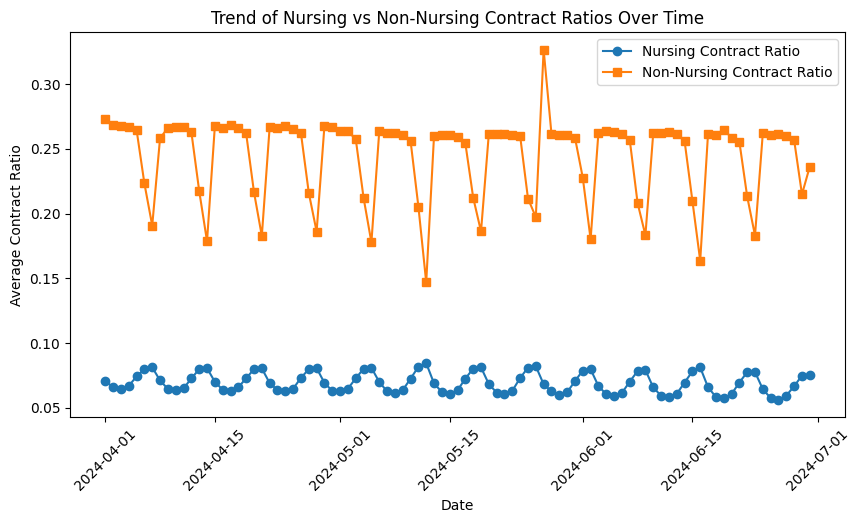

In [21]:
import matplotlib.pyplot as plt

# Aggregate by date to see trends
df_time_series = df_combined.groupby("workdate")[["nursing_ratio", "non_nursing_ratio"]].mean()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_time_series.index, df_time_series["nursing_ratio"], marker='o', label="Nursing Contract Ratio")
plt.plot(df_time_series.index, df_time_series["non_nursing_ratio"], marker='s', label="Non-Nursing Contract Ratio")
plt.title("Trend of Nursing vs Non-Nursing Contract Ratios Over Time")
plt.xlabel("Date")
plt.ylabel("Average Contract Ratio")
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [22]:
df_combined["weekday"] = df_combined["workdate"].dt.day_name()
print(df_combined.groupby("weekday")[["nursing_ratio", "non_nursing_ratio"]].mean())


In [23]:
top_spike_facilities = df_combined[df_combined["workdate"] == "2024-06-01"].nlargest(10, "non_nursing_ratio")
print(top_spike_facilities)
